In [1]:
import os,math,random, gc,datetime
import platform
import logging
logging.getLogger().setLevel(logging.CRITICAL)

#package imports
import numpy as np
import pandas as pd
from tqdm import tqdm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#local imports
from utils.helpers import find_play_type
from utils.logging import create_logger

#Stats imports
import statsmodels as sm
from scipy import stats

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')
WEEK2_PATH = os.path.join(FILE_PATH,'tracking_week_2.csv')
WEEK3_PATH = os.path.join(FILE_PATH,'tracking_week_3.csv')
WEEK4_PATH = os.path.join(FILE_PATH,'tracking_week_4.csv')
WEEK5_PATH = os.path.join(FILE_PATH,'tracking_week_5.csv')
WEEK6_PATH = os.path.join(FILE_PATH,'tracking_week_6.csv')
WEEK7_PATH = os.path.join(FILE_PATH,'tracking_week_7.csv')
WEEK8_PATH = os.path.join(FILE_PATH,'tracking_week_8.csv')
WEEK9_PATH = os.path.join(FILE_PATH,'tracking_week_9.csv')


logger = create_logger('./output/log.txt','basicModel')

Logger initialized: basicModel


### Load in all data

In [2]:
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)
week2_df = pd.read_csv(WEEK2_PATH)
week3_df = pd.read_csv(WEEK3_PATH)
week4_df = pd.read_csv(WEEK4_PATH)
week5_df = pd.read_csv(WEEK5_PATH)
week6_df = pd.read_csv(WEEK6_PATH)
week7_df = pd.read_csv(WEEK7_PATH)
week8_df = pd.read_csv(WEEK8_PATH)
week9_df = pd.read_csv(WEEK9_PATH)

#concat all weeks
all_weeks = pd.concat([week1_df,week2_df,week3_df,week4_df,week5_df,week6_df,week7_df,week8_df,week9_df])
all_weeks = all_weeks.merge(players_df.loc[:,['nflId','position']],how='left')
display(all_weeks.sample(4))

#find all pass plays and run plays
pass_plays = find_play_type(plays_df,'pass')
pass_index = plays_df[plays_df['playDescription'].isin(pass_plays)].index
pass_plays_df = plays_df.iloc[pass_index]
run_plays_df = plays_df.loc[~plays_df.index.isin(pass_index)]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,position
9938588,2022103001,4183,43441.0,Matt Ioannidis,41,2022-10-30 16:27:23.000000,99.0,CAR,right,35.80,19.76,1.61,3.36,0.17,268.89,255.57,NaN,DT
10690873,2022103010,375,53609.0,Talanoa Hufanga,19,2022-10-30 16:36:32.900000,29.0,SF,right,56.18,20.20,7.10,1.37,0.71,185.80,163.50,NaN,SS
2399927,2022091810,3549,46669.0,Jonathan Owens,6,2022-09-18 19:04:14.099999,36.0,HOU,right,48.35,22.27,6.02,0.95,0.60,205.44,202.81,pass_outcome_caught,FS
8739234,2022102303,1821,47996.0,Donovan Wilson,38,2022-10-23 14:31:51.599999,6.0,DAL,right,54.98,39.65,4.52,2.67,0.44,168.26,132.61,first_contact,SS


Number of matches for pass: 5646


In [3]:
plays_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

## Some Data Organization

In [4]:
# 8 mins
# tracking_run_index = []
# for i,j in tqdm(zip(run_plays_df['gameId'],run_plays_df['playId'])):
#     ind = all_weeks.loc[(all_weeks['gameId'] == i) & (all_weeks['playId'] == j)].index
#     tracking_run_index = tracking_run_index + ind.to_list()

# 8.5 mins
# for i in tqdm(run_plays_df[['gameId','playId']].itertuples()):
#     ind = all_weeks.loc[(all_weeks['gameId'] == i[1]) & (all_weeks['playId'] == i[2])].index
#     tracking_run_index = tracking_run_index + ind.to_list()
if not os.path.exists('./output/run_play_tracking.csv'):
    logger.info('Creating run play tracking csv...')
    #2 mins
    def apply_func(gameId,playId):
        ind = all_weeks.loc[(all_weeks['gameId'] == gameId) & (all_weeks['playId'] == playId)].index.to_list()
        return ind

    run_plays = [apply_func(x,y) for x,y in tqdm(zip(run_plays_df['gameId'],run_plays_df['playId']))]
    tracking_run_index = [item for sublist in run_plays for item in sublist]

    run_play_tracking = all_weeks.iloc[tracking_run_index]
    run_play_tracking.to_csv('./output/run_play_tracking.csv')
else:
    logger.info('Reading run play tracking csv...')
    run_play_tracking = pd.read_csv('./output/run_play_tracking.csv')

Reading run play tracking csv...


In [5]:
at_snap = run_play_tracking[run_play_tracking['event'] == 'ball_snap']
POSITION = 'SS'


test_df = at_snap[at_snap['position'] == POSITION].copy()
test_df = test_df.merge(plays_df.loc[:,['gameId','playId','playResult']],on=['gameId','playId'],how='left')

for play in tqdm(test_df.itertuples()):
    frame = play.frameId

    #frames = play[play['frameId'] == frame]
    ball = at_snap.loc[(at_snap['displayName']=='football') & (at_snap['frameId']==frame) & (at_snap['playId']==play.playId) & (at_snap['gameId']==play.gameId)]

    try:
        dist_to_ball = np.sqrt((play.x -ball['x'])**2 + (play.y-ball['y'])**2)
        test_df.loc[play.Index,'dist_to_ball'] = dist_to_ball.values[0]
    except:
        pass



6471it [00:48, 134.41it/s]


In [14]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import log_loss
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
RS = 1106

class BasicModel(BaseEstimator):
    '''
    Takes the data and fits basic models. In custom class for pipeline tweaks. Obviously unnecesary
    '''
    def __init__(self,kwargs):
        self.kwargs = kwargs
        self.rf = RandomForestRegressor(**{'n_estimators':kwargs['n_estimators'],'max_depth':kwargs['max_depth'],'random_state':RS})
        self.gbm = GradientBoostingRegressor(**kwargs)
        self.scale = StandardScaler()
        self.scaled = False
        self.rf_preds = None
        self.gbm_preds = None
        self.type = 'rf'
    
    def fit(self,X,y,scale_data=False):
        '''model fits. can scale if needed'''
        if scale_data:
            X = self.scale.fit_transform(X)
            self.scaled = True
        self.rf.fit(X,y)
        self.gbm.fit(X,y)

    def predict(self,X,y=None, gbm=False):
        '''basic predictions'''
        if self.scaled:
            X = self.scale.transform(X)

        if gbm:
            preds =  self.gbm.predict(X)
            self.gbm_preds = preds
        else:
            preds = self.rf.predict(X)
            self.rf_preds = preds

        self.preds = True
        return preds

    def score(self,X,y,gbm_pred=False):
        '''Can self score if X and y are passed in otherwise use sklearn's score method'''
        if gbm_pred:
            self.gbm_preds = self.predict(X,gbm=gbm_pred)
            return mse(y,self.gbm_preds)
        else:
            self.rf_preds = self.predict(X)
            return mse(y,self.rf_preds)
        

test_df.dropna(inplace=True)
test_cols = ['dist_to_ball','y','x','s','a','dir']

X = test_df[test_cols]
y = test_df['playResult']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RS)

params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.001,
    "loss": "squared_error",
    "random_state": RS
}

model = BasicModel(params)

model.fit(X_train,y_train,scale_data=True)
gbm_score = model.score(X_test, y_test,gbm_pred=True)
rf_score = model.score(X_test,y_test)

result_median = [y.median() for i in range(len(y_test))]
median_test = mse(y_test,result_median)



print(f'Prediction for yards gained based on {POSITION} position at snap:')
print(f'MSE for GBM: {gbm_score:.3f}')
print(f'MSE for RF: {rf_score:.3f}')
print(f'MSE for Median: {median_test:.3f}')
print(f'Improvement over median GBM: {median_test - gbm_score:.3f}')
print(f'Improvement over median RF: {median_test - rf_score:.3f}')



Prediction for yards gained based on SS position at snap:
MSE for GBM: 45.430
MSE for RF: 45.249
MSE for Median: 46.872
Improvement over median GBM: 1.442
Improvement over median RF: 1.623


### Can I predict player positions? 

In [66]:
from sklearn.ensemble import HistGradientBoostingClassifier

###processing
defense = ['FS','SS','MLB','LB','CB','DB','S','ILB','OLB','DL','NT','DE','DT']
at_snap_def = at_snap[at_snap['position'].isin(defense)].copy()


#great generalization
at_snap_def.loc[at_snap_def['position'].isin(['FS','SS','S']),'position'] = 'S'
at_snap_def.loc[at_snap_def['position'].isin(['MLB','LB','ILB','OLB']),'position'] = 'LB'
at_snap_def.loc[at_snap_def['position'].isin(['CB','DB']),'position'] = 'CB'
at_snap_def.loc[at_snap_def['position'].isin(['DL','NT','DT']),'position'] = 'DL'

at_snap_def.position.unique()

test_cols = ['y','x','s','a','o','dir']

#at_snap1 = at_snap.dropna()
X1 = at_snap_def[test_cols]
y1 = at_snap_def['position']

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.2,random_state=RS)

params = {
    "max_depth": 10,
    "min_samples_leaf": 2,
    "learning_rate": 0.1,
    "loss": "log_loss",
    "random_state": RS,
    "verbose":0,
}

model_def = HistGradientBoostingClassifier(**params)

model_def.fit(X1_train,y1_train)

gbm_preds = model_def.predict(X1_test)
print(gbm_preds)

random_pos = [random.choice(y1_test.values) for i in range(len(y1_test))]
median_test1 = metrics.precision_score(y1_test.values,random_pos,average='micro')
gbm_score1 = metrics.precision_score(y1_test.values,gbm_preds,average='micro')

median_test_cr = metrics.classification_report(y1_test.values,random_pos)
gbm_score_cr = metrics.classification_report(y1_test.values,gbm_preds)

# result_median1 = [random.choice(y1_test.values) for i in range(len(y1_test))]
# median_test1 = log_loss(y1_test.values,result_median1)
# gbm_score1 = log_loss(y1_test.values,gbm_preds)




print(f'Prediction for player postion based on positon at snap:')
print(f'Precision for GBM: {gbm_score1:.3f}')
print(f'Precision for random: {median_test1:.3f}')
print(f'Improvement over random : {gbm_score1 - median_test1:.3f}\n')

print(gbm_score_cr)

['DL' 'S' 'S' ... 'LB' 'DE' 'S']
Prediction for player postion based on positon at snap:
Precision for GBM: 0.585
Precision for random: 0.212
Improvement over random : 0.373

              precision    recall  f1-score   support

          CB       0.78      0.72      0.75      3199
          DE       0.42      0.14      0.21      1649
          DL       0.52      0.73      0.61      2460
          LB       0.52      0.62      0.57      3911
           S       0.59      0.50      0.54      2667

    accuracy                           0.58     13886
   macro avg       0.57      0.54      0.54     13886
weighted avg       0.58      0.58      0.57     13886



In [62]:
at_snap_def

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,position
5,437051,2022091103,3126,43299.0,Eli Apple,6,2022-09-11 15:34:11.599999,20.0,CIN,left,73.89,10.84,0.26,0.10,0.03,77.24,319.04,ball_snap,CB
64,437110,2022091103,3126,43350.0,Vonn Bell,6,2022-09-11 15:34:11.599999,24.0,CIN,left,71.90,35.92,2.80,1.53,0.27,89.46,77.17,ball_snap,S
123,437169,2022091103,3126,43641.0,Mike Hilton,6,2022-09-11 15:34:11.599999,21.0,CIN,left,71.92,20.79,2.67,1.18,0.26,16.84,358.09,ball_snap,CB
241,437287,2022091103,3126,44872.0,Chidobe Awuzie,6,2022-09-11 15:34:11.599999,22.0,CIN,left,68.49,41.65,0.36,0.24,0.04,117.55,293.52,ball_snap,CB
300,437346,2022091103,3126,44915.0,Trey Hendrickson,6,2022-09-11 15:34:11.599999,91.0,CIN,left,75.50,23.98,0.35,1.40,0.06,75.78,79.40,ball_snap,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457727,9193934,2022102308,905,47787.0,Clelin Ferrell,6,2022-10-23 16:44:26.700000,99.0,LV,left,25.54,24.33,0.06,0.28,0.03,77.84,142.86,ball_snap,DE
8457803,9194010,2022102308,905,47810.0,Johnathan Abram,6,2022-10-23 16:44:26.700000,24.0,LV,left,14.53,32.73,0.19,0.57,0.02,3.74,303.90,ball_snap,S
8457841,9194048,2022102308,905,47817.0,Rock Ya-Sin,6,2022-10-23 16:44:26.700000,26.0,LV,left,24.59,39.75,0.16,0.41,0.03,91.83,346.78,ball_snap,CB
8457879,9194086,2022102308,905,47889.0,Maxx Crosby,6,2022-10-23 16:44:26.700000,98.0,LV,left,25.73,34.09,0.18,0.17,0.02,90.06,103.17,ball_snap,DE


In [68]:

test_cols = ['y','x','s','a','dir','o']

at_snap1 = at_snap.dropna()
X1 = at_snap1[test_cols]
y1 = at_snap1['position']

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.2,random_state=RS)

params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "log_loss",
    "random_state": RS,
    "verbose":1,
}

model1 = GradientBoostingClassifier(**params)

model1.fit(X1_train,y1_train)


      Iter       Train Loss   Remaining Time 
         1           2.6800           31.45m
         2           2.6787           31.67m
         3           2.6774           31.75m
         4           2.6761           31.71m
         5           2.6748           31.55m
         6           2.6735           31.41m
         7           2.6722           31.32m
         8           2.6709           31.23m
         9           2.6696           31.15m
        10           2.6684           31.10m
        20           2.6559           30.40m
        30           2.6441           29.73m
        40           2.6327           29.08m
        50           2.6218           28.44m
        60           2.6113           27.79m
        70           2.6011           27.17m
        80           2.5913           26.53m
        90           2.5817           25.90m
       100           2.5724           25.27m
       200           2.4927           18.97m
       300           2.4299           12.66m
       40

GradientBoostingClassifier(learning_rate=0.001, n_estimators=500,
                           random_state=1106, verbose=1)

In [39]:
from sklearn import metrics

gbm_preds = model1.predict(X1_test)
print(gbm_preds)

random_pos = [random.choice(y1_test.values) for i in range(len(y1_test))]
median_test1 = metrics.precision_score(y1_test.values,random_pos,average='micro')
gbm_score1 = metrics.precision_score(y1_test.values,gbm_preds,average='micro')

median_test_cr = metrics.classification_report(y1_test.values,random_pos)
gbm_score_cr = metrics.classification_report(y1_test.values,gbm_preds)

# result_median1 = [random.choice(y1_test.values) for i in range(len(y1_test))]
# median_test1 = log_loss(y1_test.values,result_median1)
# gbm_score1 = log_loss(y1_test.values,gbm_preds)




print(f'Prediction for player postion based on positon at snap:')
print(f'Precision for GBM: {gbm_score1:.3f}')
print(f'Precision for random: {median_test1:.3f}')
print(f'Improvement over random : {gbm_score1 - median_test1:.3f}\n')

print(gbm_score_cr)

['T' 'C' 'CB' ... 'CB' 'G' 'T']


c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction for player postion based on positon at snap:
Precision for GBM: 45.430
Precision for random: 0.074
Improvement over random : 0.258

              precision    recall  f1-score   support

           C       0.39      0.56      0.46      1254
          CB       0.43      0.59      0.50      3084
          DB       0.00      0.00      0.00        18
          DE       0.00      0.00      0.00      1680
          DT       0.00      0.00      0.00      1939
          FB       0.00      0.00      0.00       173
          FS       0.22      0.08      0.12      1444
           G       0.31      0.69      0.42      2360
         ILB       0.22      0.01      0.01      1734
         MLB       0.00      0.00      0.00       186
          NT       0.00      0.00      0.00       539
         OLB       0.29      0.03      0.06      2007
          QB       0.34      0.29      0.31      1246
          RB       0.24      0.33      0.28      1362
          SS       0.25      0.18      0.21   

c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Linear model

In [7]:
#basic linear model
X_train1 = X_train.drop(columns=['s','dir']).copy()
X_train1['intercept'] = 1

linear_model = sm.OLS(y_train, X_train1).fit()

display(linear_model.summary())

coef = linear_model.params

change_in_unit = pd.DataFrame()

change_in_unit['coef'] = coef
change_in_unit['change_in_unit'] = np.exp(coef)
change_in_unit

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             playResult   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.422
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           0.000236
Time:                        16:09:30   Log-Likelihood:                -17111.
No. Observations:                5155   AIC:                         3.423e+04
Df Residuals:                    5150   BIC:                         3.426e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dist_to_ball     0.1093      0.024      4.595      0.000       0.063       0.156
y               -0.0099      0.014     -0.687      0.492      -0.038       0.018
x               -0.0006      0.004     -0.170      0.865      -0.008       0.006
a                0.0505      0.125      0.405      0.686      -0.194       0.295
intercept        3.2797      0.536      6.119      0.000       2.229       4.330
==============================================================================
Omnibus:                     3235.175   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101336.095
Skew:                           2.492   Prob(JB):                         0.00
Kurtosis:                      24.141   Cond. No.                         411.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,change_in_unit
dist_to_ball,0.109312,1.115510
y,-0.009875,0.990174
x,-0.000612,0.999388
a,0.050538,1.051837
intercept,3.279663,26.566829


c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


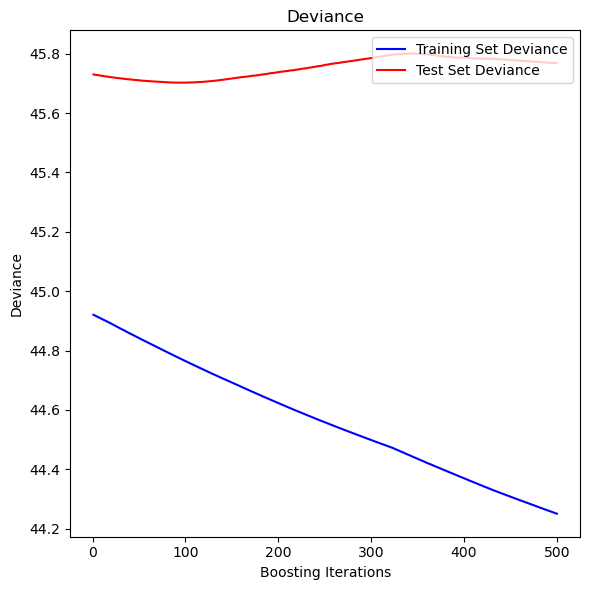

In [8]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.gbm.staged_predict(X_test)):
    test_score[i] = mse(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.gbm.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### Get the frames we might want to keep for a robust model based on movement

In [9]:
frame_counts = {}
list_of_frames = []

#average frames
for game in tqdm(run_play_tracking['gameId'].unique()):
    frame_counts[game] = {}
    for play in run_play_tracking.loc[run_play_tracking['gameId'] == game]['playId'].unique():
        frames = run_play_tracking[(run_play_tracking['gameId'] == game) & (run_play_tracking['playId'] == play)]['frameId'].mean().astype(int)
        frame_counts[game][play] = frames
        list_of_frames.append(frames)

#trim the amount of plays with less than some percentile of frames. We need every play in a tensor to have the same amount of frames
#list_of_frames.sort()
frame_threshold = np.percentile(list_of_frames, 30)
print(frame_threshold)
        

  7%|▋         | 9/136 [00:08<02:00,  1.06it/s]


KeyboardInterrupt: 

In [ ]:
#only plays with more than the threshold selected. then we ONLY take those frames
#this is to make sure that every play has the same amount of frames

keep_plays = {}

for k,v in frame_counts.items():
    keep_plays[k] = []
    for k1,v1 in v.items():
        if v1 > frame_threshold:
            keep_plays[k].append(k1)

keep_plays

{2022091103: [3126,
  253,
  274,
  1672,
  611,
  632,
  4462,
  4631,
  1610,
  520,
  2611,
  2670,
  4154,
  1126,
  1150,
  2291,
  2315,
  852,
  881,
  1493,
  1565,
  3105,
  3825,
  5039,
  1228,
  2483,
  2511,
  1384,
  2719,
  955,
  1016,
  2955,
  1315,
  1363,
  3011,
  1700,
  364,
  388,
  2201,
  2222,
  3755,
  1947,
  1968,
  2037,
  3251,
  4686,
  1037,
  4279,
  4353,
  743,
  764,
  319,
  3613,
  3680,
  1105,
  111,
  2462,
  1926,
  3294,
  3389,
  1589,
  3464,
  4789,
  340,
  2172,
  902,
  4710],
 2022091112: [2370,
  2475,
  3454,
  3492,
  3530,
  1994,
  1613,
  2612,
  2640,
  3416,
  1458,
  2501,
  965,
  86,
  1539,
  573,
  3551,
  2886,
  2072,
  181,
  3627,
  3002,
  3029,
  1144,
  1165,
  2931,
  2981,
  3766,
  1501,
  62,
  2246,
  2294,
  2167,
  2225,
  1260,
  736,
  1560,
  3589,
  3176,
  2315,
  1207,
  3128,
  3672,
  3696,
  917,
  991],
 2022091107: [723,
  3669,
  3443,
  3026,
  1260,
  1378,
  254,
  275,
  2285,
  2314,
  1994,

## A model to look at run plays and play results
Will only look at x,y,s,a,dis(or o)

In [ ]:
import torch
import torch.nn as nn

NUM_SAMPLES = 800
NUM_FRAMES = 14
NUM_PLAYERS = 23
DIMENSION_NAMES = ['x','y','s','a','o']
DIMENSIONS = len(DIMENSION_NAMES)+1



class Preprocess(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Parameter(torch.randn(1,1,3))
        self.l2 = nn.Parameter(torch.randn(1,1,3))
        self.l3 = nn.Parameter(torch.randn(1,1,3))
        
    def forward(self,x):
        x = torch.cat([x,self.l1],dim=1)
        x = torch.cat([x,self.l2],dim=1)
        x = torch.cat([x,self.l3],dim=1)
        return x

#trying to create a tensor
def create_tensor(df):
    X = np.zeros([NUM_SAMPLES, NUM_FRAMES, NUM_PLAYERS, DIMENSIONS], dtype=np.float32)
    y = np.zeros([NUM_SAMPLES], dtype=np.int32)

    for i in df['gameId'].unique():
        for j in df.loc[df['gameId'] == i]['playId'].unique():
            for p in df.loc['nflId'].unique():
                pass
            
